# This notebook is a carefully modified version of the celeba tutorial that implements new features (privacy, higher resolution, class splitting) one at a time and tests they are working before moving onto the next task.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torch.autograd import Variable

# test classes, such as "attractive-brown" are extracted to this path
#dataroot='/home/ben.gelman/celeba/classes'

# all images together are in this dir
dataroot = '/home/ben.gelman/celeba/img_align_celeba'
dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        #remove resizing so we can increase the resolution
        #transforms.Resize(32),
        #transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Pad((0,0,78,38), fill=0, padding_mode='constant')
        ])
        )

dataloader=DataLoader(dataset,num_workers=0,batch_size=64,shuffle=True)

Image dimensions: batch x channels x height x width
Image dimensions: 64 x 3 x 256 x 256


/home/ben.gelman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


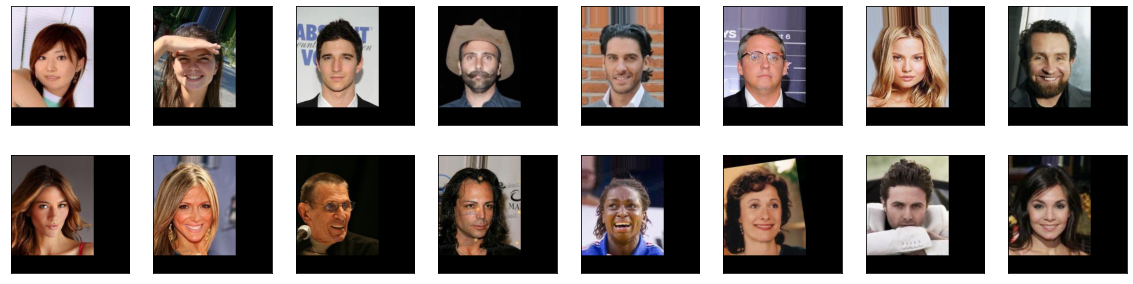

In [2]:
dataiter=iter(dataloader)
images,labels=dataiter.next()

def RGBshow(img):
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))

print(f"Image dimensions: batch x channels x height x width")
print(f"Image dimensions: {len(images)} x {len(images[0])} x {len(images[0][0])} x {len(images[0][0][0])}")
plot_only=16
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
    ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])


In [3]:
def scale(img):
    img=img*2-1
    return img

scaled_img=scale(images[0])
scaled_img.min(),scaled_img.max()

(tensor(-1.), tensor(1.))

In [4]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

def compute_immediate_sensitivity(model, inp, loss):
    cpu_loss = loss
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(
        cpu_loss,
        model.parameters(),
        retain_graph=True,
        create_graph=True,
        # allow_unused=True
    )

    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p=2)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]

    # (4) L2 norm of (3) - "immediate sensitivity"
    # sensitivity = [torch.norm(v, p=2).item() for v in sensitivity_vec]
    sensitivity = torch.norm(
        sensitivity_vec.reshape(sensitivity_vec.shape[0], -1), p=2, dim=1
    )

    return sensitivity

class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*3,4,batch_norm=False)
        self.conv4=conv(conv_dim*3,conv_dim*4,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*4*2*2,1)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*4*2*2)
        out=self.fc(x)
        return out
    
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        
        # THIS LINE OF CODE NEEDS TO BE CHANGED BASED ON WHAT YOU WANT YOUR OUTPUT SHAPE TO BE.
        # THE SECOND INPUT TO THIS NN.LINEAR IS THE NUMBER OF PARAMETERS YOU HAVE TO WORK WITH AS YOU
        # BUILD YOUR OUTPUT. So if in the line of code below you have (...,16,16) as the last two inputs
        # to the x.view, then you need to have at least 16*16 parameters in the second input to nn.Linear. 
        self.fc = nn.Linear(z_size,conv_dim*4*16*16)
        
        self.deconv1 = nn.ConvTranspose2d(conv_dim*4,conv_dim*3,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim*3)
        
        self.deconv2 = nn.ConvTranspose2d(conv_dim*3,conv_dim*2,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        
        self.deconv3 = nn.ConvTranspose2d(conv_dim*2,conv_dim,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(conv_dim)
        
        self.last_deconv = nn.ConvTranspose2d(conv_dim,3,kernel_size=4,stride=2,padding=1,bias=False)


    def forward(self,x):
        x = self.fc(x)
        
        # This line of code is CRITICAL to the output shape of the model. Those last 2 parameters to the 
        # view determine the initial shape of the image. So every time they get deconvolved, they get upscaled
        # by the stride size of the deconvolutional layer. So, for example, if (...,16,16) are the parameters
        # to the view, and your stride size on your deconvolution is 2, then each deconvolution will change
        # the output shape by a multiple of 2. 16x16 (starting) -> deconvolution,stride=2 -> 32x32 -> 
        # deconvolution,stride=2 -> 64x64 -> deconvolution,stride=2 -> 128x128 -> etc. 
        # NEED TO CHANGE THE self.fc LAYER SIZE ABOVE AS WELL
        x = x.view(-1, self.conv_dim*4, 16, 16)
        
        # deconv1
        x = self.deconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # deconv2
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        # deconv3
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        # last deconvolution
        x = self.last_deconv(x)
        
        out = F.tanh(x)
        return out
    
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

z_size=200
D=Discriminator(64)
G=Generator(z_size,64)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(192, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=200, out_features=65536, bias=True)
  (deconv1): ConvTranspose2d(256, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(192, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

The shapes on the model above can get quite confusing... here's an attempt at an explanation.

The z_dim determines the in_features of the generator, but it seems to only be used at the beginning. I think that z_dim is the size of the random noise given to the generator to work with in order to produce an image. 



In [5]:
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

def real_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size) * 0.9

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size)

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss    
  
  
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

In [8]:
import pickle as pkl
import time

def train(D, G, n_epochs, print_every=300, dp_training=False, alpha=2, epsilon=1e5):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    start = time.time()
    
    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()

    # if dp_training is enabled, this will be used in the computation, otherwise ignored
    epsilon_iter = epsilon / n_epochs    
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            
            # DP step 1: prepare data
            if dp_training:
                real_images = Variable(real_images, requires_grad=True)
            
            
            if use_cuda and torch.cuda.is_available():
                real_images = real_images.cuda()
                
            # Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            
            # DP step 2: call sensitivity computation
            if dp_training:
                batch_sensitivities = compute_immediate_sensitivity(
                    D, real_images, d_real_loss
                )
                batch_sensitivity = torch.max(batch_sensitivities) / len(real_images)
            
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            
            # DP step 3: compute noise and scale gradients
            if dp_training:
                sigma = torch.sqrt(
                    (batch_sensitivity ** 2 * alpha) / (2 * epsilon_iter)
                )

                # step 5. update gradients with computed sensitivities
                with torch.no_grad():
                    for p in D.parameters():
                        if use_cuda and torch.cuda.is_available(): 
                            p.grad += sigma * torch.randn(1).cuda()
                        else:
                            p.grad += sigma * torch.randn(1)
            
            # now take the actual step according to the (sensitivity-modified) gradients
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()


            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | time: {:f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), time.time()-start))

        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        # Save training generator samples
        with open(f'samples/moddp/train_samples_epoch{epoch}.pkl', 'wb') as f:
            pkl.dump([samples_z], f)
        G.train() # back to training mode

    
    # finally return losses
    return losses
  
  

n_epochs = 10


dp_training = True
losses = train(D, G, n_epochs=n_epochs, dp_training=dp_training, alpha=2, epsilon=1e6)


'''
# call training function
losses = train(D, G, n_epochs=n_epochs)
'''

Epoch [    1/    1] | d_loss: 1.3863 | g_loss: 0.6917 | time: 0.828545
Epoch [    1/    1] | d_loss: 0.4529 | g_loss: 0.3293 | time: 212.094713
Epoch [    1/    1] | d_loss: 0.4619 | g_loss: 0.3427 | time: 422.218711
Epoch [    1/    1] | d_loss: 0.5531 | g_loss: 0.3302 | time: 637.433515
Epoch [    1/    1] | d_loss: 0.6358 | g_loss: 0.3402 | time: 852.252045
Epoch [    1/    1] | d_loss: 0.4390 | g_loss: 0.3667 | time: 1068.870620
Epoch [    1/    1] | d_loss: 0.5147 | g_loss: 0.3490 | time: 1283.672913
Epoch [    1/    1] | d_loss: 0.5049 | g_loss: 0.3492 | time: 1500.339186
Epoch [    1/    1] | d_loss: 0.4973 | g_loss: 0.3280 | time: 1717.114922
Epoch [    1/    1] | d_loss: 0.4885 | g_loss: 0.3283 | time: 1932.425579
Epoch [    1/    1] | d_loss: 0.4551 | g_loss: 0.3332 | time: 2147.058277


'\n# call training function\nlosses = train(D, G, n_epochs=n_epochs)\n'

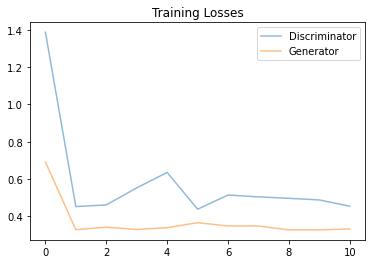

In [9]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [10]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch):
    with open(f'samples/moddp/train_samples_epoch{epoch}.pkl', 'rb') as f:
        samples = pkl.load(f)
    
    fig, axes = plt.subplots(figsize=(20,5), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[0]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((256,256,3)))
        #im = ax.imshow(img.reshape((32,32,3)))
        

# Load samples from generator, taken while training
view_samples(n_epochs-1)

FileNotFoundError: [Errno 2] No such file or directory: 'samples/moddp/train_samples_epoch54.pkl'

# Shape testing to learn how deconvolutions work

In [ ]:
'''
z = np.random.uniform(-1, 1, size=(64, z_size))
z = torch.from_numpy(z).float()
z=z.cuda()
result = G(z)
print(f"Dimensions: {len(result)} x {len(result[0])} x {len(result[0][0])} x {len(result[0][0][0])}")

# With square kernels and equal stride
m = nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1)
inp = torch.randn(128, 256, 50, 100)
output = m(inp)
print(f"Dimensions: {len(output)} x {len(output[0])} x {len(output[0][0])} x {len(output[0][0][0])}")

# exact output size can be also specified as an argument
inp = torch.randn(1, 16, 12, 12)
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
h = downsample(inp)
print(h.size())
#torch.Size([1, 16, 6, 6])
output = upsample(h, output_size=inp.size())
print(inp.size())
print(output.size())
#torch.Size([1, 16, 12, 12])
'''